In [17]:
import sys

sys.path.append('../')

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.fft import fftshift, fft2, ifft2, ifftn, ifftshift
from tqdm import tqdm

from models.DAS import DAS
from models.PACT import PSF_PACT
from models.Wiener import Wiener_Batched
from utils.data import *
from utils.simulations import *
from utils.utils_torch import get_fourier_coord
from utils.reconstruction import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_path = '../data/'

In [18]:
sinogram = load_mat(os.path.join(data_path, 'sinogram_simulation.mat'))
sinogram += np.random.normal(0, 1e-4, sinogram.shape)

In [19]:
Nx, Ny = 560, 560
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec
l = 3.2e-3 # Patch size [m].

In [20]:
R = 9.8e-3              # Radius of single body [m].
T = 26.0                # Water temperature [C].
v0 = get_water_SoS(T)   # Background SoS [m/s].
v1 = 1567.3             # Avergae SoS in single body [m/s].
print(v0, v1)

1499.3632858457756 1567.3


In [21]:
fwhm = 1.5e-3 # [m]
sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
gaussian_window = torch.tensor(gaussian_kernel(sigma, 80), device=device)

In [22]:
def get_coordinates(i, j, l):
    x, y = (j-12)*l / 4, (12-i)*l / 4
    r, phi = np.sqrt(x**2 + y**2), np.arctan2(x, y)
    return x, y, r, phi

i, j = 16, 16
x, y, r, phi = get_coordinates(i, j, l)
k2D, theta2D = get_fourier_coord(n_points=80, l=3.2e-3, device='cpu')

In [23]:
delays = np.linspace(-8e-4, 8e-4, 32)

psf_pact = PSF_PACT(n_points=80, l=l, n_delays=delays.shape[0], device=device)
psf_pact.to(device)
psf_pact.eval()

das = DAS(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, mode='zero', device=device)
das.to(device)
das.eval()

wiener = Wiener_Batched(lam=5., device=device)
wiener.to(device)
wiener.eval()

Wiener_Batched()

In [24]:
img_stack = []
with torch.no_grad():
    for d_delay in tqdm(delays):
        recon = das(sinogram=torch.tensor(sinogram).to(device), 
                    v0=torch.tensor(v0, device=device),
                    d_delay=torch.tensor(d_delay, device=device),
                    ring_error=torch.zeros(1, device=device))
        img_stack.append(recon)
img_stack = torch.stack(img_stack, dim=0)

100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


In [25]:
obs = img_stack[:,20*i:20*i+80, 20*j:20*j+80]
w_real = wavefront_real(R, r, phi, v0, v1)
psf = psf_pact(torch.tensor(delays, device=device).view(1,-1,1,1), w_real)
mean = obs.abs().mean()
obs = obs.unsqueeze(0) * gaussian_window
rec = wiener(obs/mean, psf) * mean
rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()

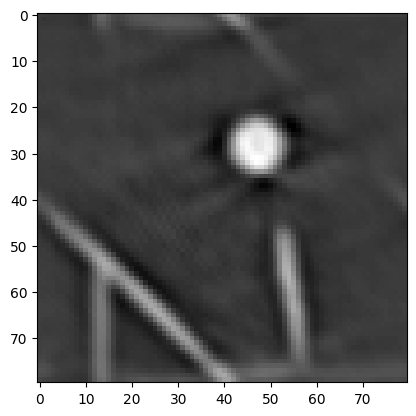

In [26]:
plt.imshow(rec, cmap='gray')

In [27]:
from torch.fft import fftshift, fft2, ifft2, ifftn, ifftshift
def PSF(theta, k, w, delay):
    tf = (torch.exp(-1j*k*(delay - w(theta))) + torch.exp(1j*k*(delay - w(theta+torch.pi)))) / 2
    psf = ifftshift(ifft2(fftshift(tf, dim=[-2,-1])), dim=[-2,-1]).abs()
    psf /= psf.sum(axis=(-2,-1)) # Normalization.
    return psf

def TF(theta, k, w, delay):
    tf = (torch.exp(-1j*k*(delay - w(theta))) + torch.exp(1j*k*(delay - w(theta+np.pi)))) / 2
    return tf

def condition_number(psf):
    """Calculate the condition number of a PSF.

    Args:
        tf (`numpy.ndarray`): PSF image.

    Returns:
        `float`: Condition number.
    """
    H = fft2(psf)
    return H.abs().max() / H.abs().min()    

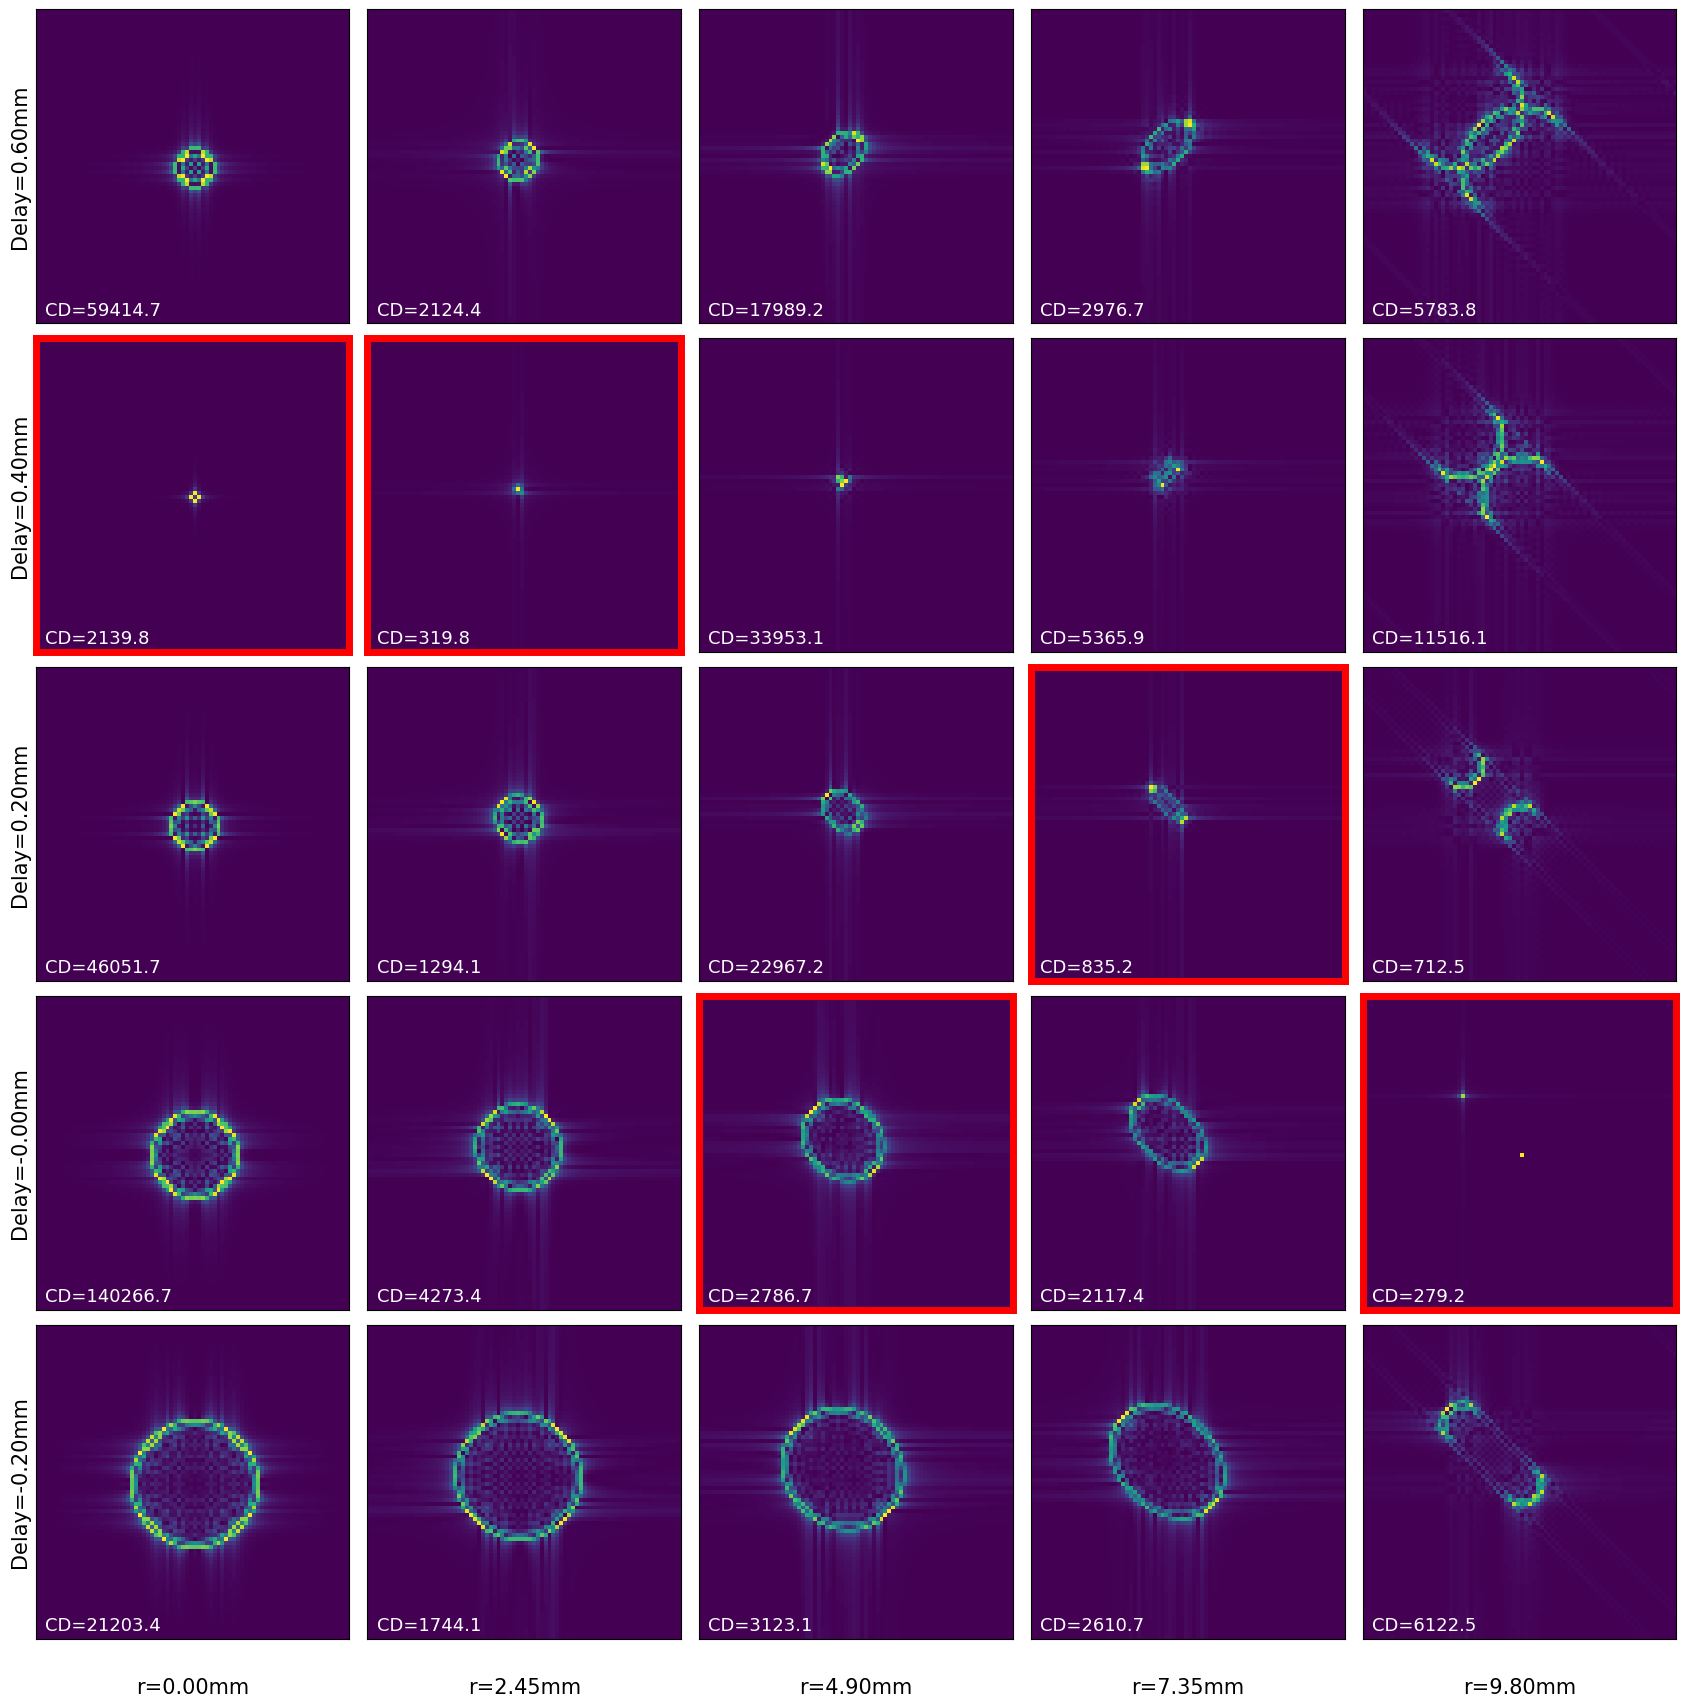

In [29]:
n_delays = 5
delays_fig = np.linspace(-2e-4, 6e-4, n_delays)
rs = np.linspace(0, R, n_delays)

fig = plt.figure(figsize=(17, 17))
for i, r in enumerate(rs):
    psfs = []
    w_real = wavefront_real(R, r, phi, v0, v1)
    CD_min = np.inf
    for j, delay in enumerate(delays_fig):
        psfs.append(PSF(theta2D, k2D, w_real, delay))
        cd = condition_number(psfs[j])
        if cd < CD_min:
            CD_min = cd
            CD_min_idx = j
    for j, delay in enumerate(delays_fig):
        ax = plt.subplot(n_delays, len(rs), i+1+len(rs)*(n_delays-j-1))
        plt.imshow(psfs[j])
        plt.xticks([])
        plt.yticks([])
        plt.title('CD={:.1f}'.format(condition_number(psfs[j])), fontsize=13, loc='left', y=0.0, x=0.03, color='white')
        if i == 0:
            plt.ylabel('Delay={:.2f}mm'.format(delays_fig[j]*1e3), fontsize=15)
        if j == 0:
            plt.title('r={:.2f}mm'.format(r*1e3), fontsize=15, y=-0.2)
        if j == CD_min_idx:
            for loc in ['bottom', 'top', 'left', 'right']:
                ax.spines[loc].set_color('red')
                ax.spines[loc].set_linewidth(5)
            
plt.tight_layout()